In [1]:
# Loading all the needed Packages
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

# Import classes from Class.py
from Data_handling import *
from Class import *
from Class_no_zone import *

In [2]:
## DATA INDEX

#Data_df

In [3]:
## PARAMETERS DEFINITION

# Time
H = 24          # Hours in a day
D = 5           # Typical days in a year
Y = 30          # Years of the investment timeline
N = H*D*Y       # Number of hours in the investment timeline    


# Number of loads and generators
N_dem = len(Dem[0,:])       # Number of loads
N_gen_E = len(Gen_E_OpCost)   # Number of existing generators
N_gen_N = len(Gen_N_OpCost)   # Number of new generators
N_zone = len(Trans_Z_Connected_To_Z)     # Number of zones
N_line = len(Trans_Line_From_Z)   # Number of transmission lines


# Hyperparameters
B = 1000000000   # Budget for the investment problem
R = 73 # Conversion rate


In [4]:
## CREATE THE PARAMETERS AND DATA OBJECTS
ParametersObj = Parameters(H, D, Y, N, N_dem, N_gen_E, N_gen_N, N_zone, N_line, B, R, N_S, N_S_test, max_deviation)
DataObj = InputData(Dem, Uti, Load_Z, Gen_E_OpCost, Gen_N_OpCost, Gen_N_MaxInvCap, Gen_E_Cap, Gen_N_InvCost, Gen_E_Tech, Gen_N_Tech, Gen_E_Z, Gen_N_Z, Gen_E_OpCap, Gen_N_OpCap, Trans_React, Trans_Cap, Trans_Line_From_Z, Trans_Line_To_Z, Trans_Z_Connected_To_Z,Gen_N_Data_scenarios,Gen_N_OpCost_scenarios, Gen_N_Data_scenarios_train, Gen_N_OpCost_scenarios_train, Gen_N_Data_scenarios_test, Gen_N_OpCost_scenarios_test)

# Model 1: Sequential optimization of Dispatch problem and Investment problem

### 1) Market Clearing

In [5]:
# Run the Market Clearing Problem
MarketClearing1 = MarketClearingModel1(ParametersObj, DataObj)

Set parameter Username


Academic license - for non-commercial use only - expires 2025-11-07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 140400 rows, 126000 columns and 270000 nonzeros
Model fingerprint: 0x4c1471a4
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [3e+01, 1e+03]
  Bounds range     [1e+03, 1e+03]
  RHS range        [4e-01, 1e+03]
Presolve removed 134239 rows and 109069 columns
Presolve time: 0.42s
Presolved: 6161 rows, 16931 columns, 19670 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.739e+03
 Factor NZ  : 8.900e+03 (roughly 10 MB of memory)
 Factor Ops : 1.438e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objectiv

### 2) Investment Problem

In [6]:
# Run the investmentmodel
InvestmentPB1 = InvestmentModel1(ParametersObj, DataObj, MarketClearing1.res.DA_price)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 57857 rows, 57616 columns and 111932 nonzeros
Model fingerprint: 0xbaa5e9fc
Coefficient statistics:
  Matrix range     [4e-04, 1e+06]
  Objective range  [1e+03, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 1e+09]
Presolve removed 57856 rows and 57610 columns
Presolve time: 0.11s
Presolved: 1 rows, 6 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.2734490e+10   3.072000e+05   0.000000e+00      0s
       1    2.1889150e+10   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.16 seconds (0.06 work units)
Optimal objective  2.188915000e+10
Objective value:  21889150000.0


In [7]:
InvestmentPB1.res.df

,Technology,Invested capacity (MW)
0,Coal,0.0
1,Coal,0.0
2,Coal,0.0
3,Gas,0.0
4,Coal,0.0
5,Wind,400.0
6,Wind,200.0
7,PV,0.0
8,Gas,0.0
9,Coal,0.0


### 3) Stochastic robust investment problem

In [8]:
  
# Class for the robust stochastic model
class InvestmentModel_Robust1():
    def __init__(self, Parameters, Data, DA_Price, Model_results = 1, Guroby_results = 1):
        self.D = Data  # Data
        self.P = Parameters  # Parameters
        self.DA_Price = DA_Price  # Day-ahead price
        self.Model_results = Model_results  # Display results
        self.Guroby_results = Guroby_results  # Display guroby results
        self.var = Expando()  # Variables
        self.con = Expando()  # Constraints
        self.res = Expando()  # Results
        self._build_model() 


    def _build_variables(self):
        self.var.P_N = self.m.addMVar((self.P.N_gen_N), lb=0) # Invested capacity in every new generator
        self.var.p_N = self.m.addMVar((self.P.N, self.P.N_gen_N, self.P.N_S), lb=0) # Power output per hour for every new generator


    def _build_constraints(self):
        # Capacity investment constraint
        self.con.cap_inv = self.m.addConstr(self.var.P_N <= self.D.Gen_N_MaxInvCap, name='Maximum capacity investment')

        # Max production constraint
        for s in range(self.P.N_S):
            self.con.max_p_N = self.m.addConstr(self.var.p_N[:,:,s] <= self.D.Gen_N_OpCap * self.var.P_N, name='Maximum RES production') 

        # Budget constraint
        for s in range(self.P.N_S):
            self.con.budget = self.m.addConstr(self.var.P_N @ self.D.Gen_N_Data_scenarios[:,s] <= self.P.B, name='Budget constraint')


    def _build_objective(self):
        revenues = (gp.quicksum((self.var.p_N[:,:,s] @ self.D.Gen_N_Z.T for s in range(self.P.N_S))) *  self.DA_Price).sum()
        op_costs = (gp.quicksum(self.var.p_N[:,:,s] @ self.D.Gen_N_OpCost_scenarios[:,s] for s in range(self.P.N_S))).sum()
        invest_costs = gp.quicksum(self.var.P_N @ self.D.Gen_N_Data_scenarios[:,s] for s in range(self.P.N_S))
        objective = (1/self.P.N_S) * (self.P.R*(revenues - op_costs) - invest_costs)
        self.m.setObjective(objective, GRB.MAXIMIZE)


    def _display_guropby_results(self):
        self.m.setParam('OutputFlag', self.Guroby_results)
    

    def _build_model(self):
        self.m = gp.Model('Investment problem')
        self._build_variables()  
        self._build_constraints()
        self._build_objective()
        #self._display_guropby_results()
        self.m.optimize()
        if self.Model_results == 1:
            self._extract_results()

    def _extract_results(self):
        # Display the objective value
        print('Objective value: ', self.m.objVal)
        
        # Display the generators the model invested in, in a dataframe
        self.res.P_N = self.var.P_N.X
        self.res.P_N = self.res.P_N.reshape((self.P.N_gen_N,1))
        self.res.df = pd.DataFrame(self.D.Gen_N_Tech, columns = ['Technology'])
        self.res.df['Invested capacity (MW)'] = self.res.P_N    

        # Display the objective value of each scenario and save it in a list
        self.res.objective_values = []
        for s in range(self.P.N_S):
            revenues = (self.var.p_N[:,:,s].X @ self.D.Gen_N_Z.T * self.DA_Price).sum()
            op_costs = (self.var.p_N[:,:,s].X @ self.D.Gen_N_OpCost_scenarios[:,s]).sum()
            invest_costs = (self.var.P_N.X @ self.D.Gen_N_Data_scenarios[:,s]).sum()
            objective = self.P.R*(revenues - op_costs) - invest_costs
            self.res.objective_values.append(objective)
            #print('Objective value for scenario ', s, ': ', objective)

In [9]:
#Run the stochastic investment model (without scenario dependent variables)
Investment_Robust = InvestmentModel_Robust1(ParametersObj, DataObj, MarketClearing1.res.DA_price)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 288261 rows, 288016 columns and 558636 nonzeros
Model fingerprint: 0x9b8212fc
Coefficient statistics:
  Matrix range     [4e-04, 2e+06]
  Objective range  [4e+00, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 1e+09]
Presolve removed 288256 rows and 288000 columns
Presolve time: 0.56s
Presolved: 5 rows, 16 columns, 80 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.8582970e+10   2.700336e+06   0.000000e+00      1s
       5    1.9570806e+10   0.000000e+00   0.000000e+00      1s

Solved in 5 iterations and 0.84 seconds (0.30 work units)
Optimal objective  1.957080621e+10
Objective value:  19570806212.786293


In [10]:
Investment_Robust.res.df

,Technology,Invested capacity (MW)
0,Coal,0.000000
1,Coal,0.000000
2,Coal,0.000000
3,Gas,0.000000
4,Coal,0.000000
5,Wind,240.966479
6,Wind,400.000000
7,PV,0.000000
8,Gas,0.000000
9,Coal,0.000000


### 3) Chance Constraint

In [11]:
class InvestmentModel_Stochastic_ChanceConstraint1():
    def __init__(self, Parameters, Data, DA_Price, epsilon = 0.1, Model_results = 1, Guroby_results = 1):
        self.D = Data  # Data
        self.P = Parameters  # Parameters
        self.DA_Price = DA_Price  # Day-ahead price
        self.epsilon = epsilon  # Chance constraint
        self.Model_results = Model_results  # Display results
        self.Guroby_results = Guroby_results  # Display guroby results
        self.var = Expando()  # Variables
        self.con = Expando()  # Constraints
        self.res = Expando()  # Results
        self._build_model() 


    def _build_variables(self):
        self.var.P_N = self.m.addMVar((self.P.N_gen_N), lb=0) # Invested capacity in every new generator
        self.var.p_N = self.m.addMVar((self.P.N, self.P.N_gen_N, self.P.N_S), lb=0) # Power output per hour for every new generator
        self.var.u = self.m.addMVar((self.P.N_S), vtype=GRB.BINARY) # Binary variable for each scenario

    def _build_constraints(self):
        # Capacity investment constraint
        self.con.cap_inv = self.m.addConstr(self.var.P_N <= self.D.Gen_N_MaxInvCap, name='Maximum capacity investment')

        # Max production constraint
        for s in range(self.P.N_S):
            self.con.max_p_N = self.m.addConstr(self.var.p_N[:,:,s] <= self.D.Gen_N_OpCap * self.var.P_N, name='Maximum RES production') 

        # Budget constraint
        for s in range(self.P.N_S):
            self.con.budget = self.m.addConstr(self.var.P_N @ self.D.Gen_N_Data_scenarios[:,s] - self.P.B <= (1-self.var.u[s])*self.P.Big_M, name='Budget constraint')

         # Chance constraint
        self.con.chance = self.m.addConstr( (self.var.u).sum() /self.P.N_S >= (1-self.epsilon), name='Chance constraint')


    def _build_objective(self):
        revenues = (gp.quicksum((self.var.p_N[:,:,s] @ self.D.Gen_N_Z.T for s in range(self.P.N_S))) *  self.DA_Price).sum()
        op_costs = (gp.quicksum(self.var.p_N[:,:,s] @ self.D.Gen_N_OpCost_scenarios[:,s] for s in range(self.P.N_S))).sum()
        invest_costs = gp.quicksum(self.var.P_N @ self.D.Gen_N_Data_scenarios[:,s] for s in range(self.P.N_S))
        objective = (1/self.P.N_S) * (self.P.R*(revenues - op_costs) - invest_costs)

        self.m.setObjective(objective, GRB.MAXIMIZE)


    def _display_guropby_results(self):
        self.m.setParam('OutputFlag', self.Guroby_results)
    

    def _build_model(self):
        self.m = gp.Model('Investment problem')
        self._build_variables()  
        self._build_constraints()
        self._build_objective()
        #self._display_guropby_results()
        self.m.optimize()
        if self.Model_results == 1:
            self._extract_results()

    def _extract_results(self):
        # Display the objective value
        print('Objective value: ', self.m.objVal)
        
        # Display the generators the model invested in, in a dataframe
        self.res.P_N = self.var.P_N.X
        self.res.P_N = self.res.P_N.reshape((self.P.N_gen_N,1))
        self.res.df = pd.DataFrame(self.D.Gen_N_Tech, columns = ['Technology'])
        self.res.df['Invested capacity (MW)'] = self.res.P_N  

        # Display the objective value of each scenario and save it in a list
        self.res.objective_values = []
        self.res.violated_budget = []
        for s in range(self.P.N_S):
            revenues = (self.var.p_N[:,:,s].X @ self.D.Gen_N_Z.T * self.DA_Price).sum()
            op_costs = (self.var.p_N[:,:,s].X @ self.D.Gen_N_OpCost_scenarios[:,s]).sum()
            invest_costs = (self.var.P_N.X @ self.D.Gen_N_Data_scenarios[:,s]).sum()
            objective = self.P.R*(revenues - op_costs) - invest_costs
            self.res.objective_values.append(objective)
            self.res.violated_budget.append(self.var.u[s].X)
            #print('Objective value for scenario ', s, ': ', objective)

      



In [12]:
Investment_Stochastic_ChanceConstraint = InvestmentModel_Stochastic_ChanceConstraint1(ParametersObj, DataObj, MarketClearing1.res.DA_price, epsilon = 0.8)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 288262 rows, 288021 columns and 558646 nonzeros
Model fingerprint: 0x11d0bd01
Variable types: 288016 continuous, 5 integer (5 binary)
Coefficient statistics:
  Matrix range     [4e-04, 2e+09]
  Objective range  [4e+00, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 3e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective -0.0000000
Presolve removed 288240 rows and 287984 columns
Presolve time: 1.14s
Presolved: 22 rows, 37 columns, 122 nonzeros
Variable types: 32 continuous, 5 integer (5 binary)

Root relaxation: objective 4.206100e+10, 7 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds   

### 4) CVaR Model

In [13]:
  
# Class for the robust stochastic model
class InvestmentModel_CVaR():
    def __init__(self, Parameters, Data, DA_Price, Beta = 0.5, Alpha = 0.95, Model_results = 1, Guroby_results = 1):
        self.D = Data  # Data
        self.P = Parameters  # Parameters
        self.DA_Price = DA_Price  # Day-ahead price
        self.beta = Beta
        self.alpha = Alpha
        self.Model_results = Model_results  # Display results
        self.Guroby_results = Guroby_results  # Display guroby results
        self.var = Expando()  # Variables
        self.con = Expando()  # Constraints
        self.res = Expando()  # Results
        self._build_model() 


    def _build_variables(self):
        self.var.P_N = self.m.addMVar((self.P.N_gen_N), lb=0) # Invested capacity in every new generator
        self.var.p_N = self.m.addMVar((self.P.N, self.P.N_gen_N, self.P.N_S), lb=0) # Power output per hour for every new generator
        self.var.eta = self.m.addMVar((self.P.N_S), lb=0,ub=GRB.INFINITY)# Eta for each scenario
        self.var.zeta = self.m.addMVar((1), lb=-GRB.INFINITY, ub=GRB.INFINITY) # Zeta for the VaR

    def _build_constraints(self):
        # Capacity investment constraint
        self.con.cap_inv = self.m.addConstr(self.var.P_N <= self.D.Gen_N_MaxInvCap, name='Maximum capacity investment')

        # Max production constraint
        for s in range(self.P.N_S):
            self.con.max_p_N = self.m.addConstr(self.var.p_N[:,:,s] <= self.D.Gen_N_OpCap * self.var.P_N, name='Maximum RES production') 

        # Budget constraint
        for s in range(self.P.N_S):
            self.con.budget = self.m.addConstr(self.var.P_N @ self.D.Gen_N_Data_scenarios[:,s] <= self.P.B, name='Budget constraint')

        # CVaR constraint
        for s in range(self.P.N_S):
            self.con.CVaR = self.m.addConstr(self.var.eta[s] >= self.var.zeta 
                -self.P.R*((self.var.p_N[:,:,s] @ self.D.Gen_N_Z.T) *  self.DA_Price).sum() # revenues
            +   self.P.R*gp.quicksum((self.var.p_N[:,:,s] @ self.D.Gen_N_OpCost_scenarios[:,s])) # operational costs
            +   self.var.P_N @ self.D.Gen_N_Data_scenarios[:,s] # investment costs
            , name='CVaR constraint')

    def _build_objective(self):
        revenues = (gp.quicksum((self.var.p_N[:,:,s] @ self.D.Gen_N_Z.T for s in range(self.P.N_S))) *  self.DA_Price).sum()
        op_costs = (gp.quicksum(self.var.p_N[:,:,s] @ self.D.Gen_N_OpCost_scenarios[:,s] for s in range(self.P.N_S))).sum()
        invest_costs = gp.quicksum(self.var.P_N @ self.D.Gen_N_Data_scenarios[:,s] for s in range(self.P.N_S))
        self.CVaR = self.var.zeta - (1/(1-self.alpha)) * gp.quicksum(self.var.eta[s] * (1/self.P.N_S) for s in range(self.P.N_S))
        self.expected_result = (1/self.P.N_S)*(self.P.R*(revenues - op_costs) - invest_costs)
        objective = (1-self.beta)*self.expected_result + self.beta*self.CVaR
        self.m.setObjective(objective, GRB.MAXIMIZE)


    def _display_guropby_results(self):
        self.m.setParam('OutputFlag', self.Guroby_results)
    

    def _build_model(self):
        self.m = gp.Model('Investment problem')
        self._build_variables()  
        self._build_constraints()
        self._build_objective()
        self.m.setParam('Presolve', 2) # Aggressive presolve
        #self._display_guropby_results()
        self.m.optimize()
        if self.Model_results == 1:
            self._extract_results()

    def _extract_results(self):
        # Display the objective value
        print('Objective value: ', self.m.objVal)
        #display the CVaR
        print('CVaR: ', self.CVaR.getValue())
        #Display zeta
        print('Zeta: ', self.var.zeta.X)
        #Display eta
        print('Eta: ', self.var.eta.X)
        
        # Display the generators the model invested in, in a dataframe
        self.res.P_N = self.var.P_N.X
        self.res.P_N = self.res.P_N.reshape((self.P.N_gen_N,1))
        self.res.CVaR = self.CVaR.getValue()
        self.res.Zeta = self.var.zeta.X
        self.res.Expected_Result = self.expected_result.getValue()
        self.res.df = pd.DataFrame(self.D.Gen_N_Tech, columns = ['Technology'])
        self.res.df['Invested capacity (MW)'] = self.res.P_N 

        # Display the objective value of each scenario and save it in a list
        self.res.objective_values = []
        for s in range(self.P.N_S):
            revenues = (self.var.p_N[:,:,s].X @ self.D.Gen_N_Z.T * self.DA_Price).sum()
            op_costs = (self.var.p_N[:,:,s].X @ self.D.Gen_N_OpCost_scenarios[:,s]).sum()
            invest_costs = (self.var.P_N.X @ self.D.Gen_N_Data_scenarios[:,s]).sum()
            objective = self.P.R*(revenues - op_costs) - invest_costs
            self.res.objective_values.append(objective)
            #print('Objective value for scenario ', s, ': ', objective)
             

In [14]:
Investment_CVaR = InvestmentModel_CVaR(ParametersObj, DataObj, MarketClearing1.res.DA_price, Beta = 0.5, Alpha = 0.95)

Set parameter Presolve to value 2
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-5350U CPU @ 1.80GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 288266 rows, 288022 columns and 842946 nonzeros
Model fingerprint: 0xa8ba8936
Coefficient statistics:
  Matrix range     [4e-04, 2e+06]
  Objective range  [5e-01, 5e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 1e+09]
Presolve removed 70251 rows and 70000 columns (presolve time = 24s) ...
Presolve removed 80251 rows and 80000 columns (presolve time = 49s) ...
Presolve removed 90251 rows and 90000 columns (presolve time = 75s) ...
Presolve removed 100251 rows and 100000 columns (presolve time = 98s) ...
Presolve removed 110251 rows and 110000 columns (presolve time = 119s) ...
Presolve removed 120251 rows and 120000 columns (presolve time = 139s) ...
Presolve removed 130251 rows and 130000 columns (p

In [15]:
Investment_CVaR.res.df

,Technology,Invested capacity (MW)
0,Coal,0.000000e+00
1,Coal,0.000000e+00
2,Coal,0.000000e+00
3,Gas,0.000000e+00
4,Coal,0.000000e+00
5,Wind,2.409665e+02
6,Wind,4.000000e+02
7,PV,0.000000e+00
8,Gas,0.000000e+00
9,Coal,0.000000e+00


## Test & Train models

In [11]:
class Test_and_Train_model():
    def __init__(self, Parameters, Data, DA_Price, Mode = 'Robust', Type = 'Train', Targets = np.ones((N_gen_N,1)) ,epsilon = 0.1, Beta=0.5, Alpha=0.95, Model_results=True, Guroby_results=False):
        self.D = Data  # Data
        self.P = Parameters  # Parameters
        # self.DA_Price_reduced = DA_Price  # Day-ahead price
        self.Mode = Mode
        self.Type = Type
        self.Targets = Targets
        self.epsilon = epsilon
        self.beta = Beta
        self.alpha = Alpha
        self.Model_results = Model_results  # Display results
        self.Guroby_results = Guroby_results  # Display Gurobi results
        self.var = Expando()  # Variables
        self.con = Expando()  # Constraints
        self.res = Expando()  # Results

        # Reduce the computationnal time
        self.P.N_reduced = self.P.N // 30 # Number of hours in 1 year
        self.D.Gen_N_OpCap_reduced = self.D.Gen_N_OpCap[0:120] # Gen_N_OpCap for 1 year
        self.P.R_year = self.P.R * 30 # Conversion rate for 1 year
        self.DA_Price_reduced = DA_Price[0:120] # DA_Price for 1 year
        if self.Type == 'Train':
            self.N_S = N_S_train
            self.OPEX_Cost = self.D.Gen_N_OpCost_scenarios_train
            self.CAPEX_Cost = self.D.Gen_N_Data_scenarios_train
        if self.Type == 'Test':
            self.N_S = N_S_test
            self.OPEX_Cost = self.D.Gen_N_OpCost_scenarios_test
            self.CAPEX_Cost = self.D.Gen_N_Data_scenarios_test
        if self.Type == 'Train' and self.Mode == 'Deterministic':
            self.N_S = 1
            self.OPEX_Cost = self.D.Gen_N_OpCost_scenarios_train.mean(axis=1).reshape((self.P.N_gen_N,1))
            self.CAPEX_Cost = self.D.Gen_N_Data_scenarios_train.mean(axis=1).reshape((self.P.N_gen_N,1))
            
        self._build_model()
        

    def _build_variables(self):
        self.var.P_N = self.m.addMVar((self.P.N_gen_N), lb=0, name="Invested_Capacity")  
        self.var.p_N = self.m.addMVar((self.P.N_reduced, self.P.N_gen_N, self.N_S), lb=0, name="Power_Output") 

        if self.Mode == 'Chance':
            self.var.u = self.m.addMVar((self.N_S), vtype=GRB.BINARY) # Binary variable for each scenario

        if self.Mode == 'CVaR' and self.Type == 'Train':
            self.var.eta = self.m.addMVar((self.N_S), lb=0, name="Eta")  
            self.var.zeta = self.m.addVar(lb=-GRB.INFINITY, name="Zeta")  

    def _build_constraints(self):
        # Capacity investment constraint
        self.con.cap_inv = self.m.addConstr(self.var.P_N <= self.D.Gen_N_MaxInvCap, name='Max_Investment_Capacity')
        
        # Max production constraints for all scenarios
        self.con.max_p_N = self.m.addConstrs(
            (self.var.p_N[:, :, s] <= self.D.Gen_N_OpCap_reduced * self.var.P_N for s in range(self.N_S)), name="Max_Production")
        
        # Budget constraint 
        if self.Mode == 'Robust' or self.Mode == 'CVaR' or self.Mode == 'Deterministic':
            if self.Type == 'Train':
                for s in range(self.N_S):
                    self.con.budget = self.m.addConstr(self.var.P_N @ self.CAPEX_Cost[:,s] <= self.P.B_test_train, name='Budget constraint')
        
        if self.Mode == 'Chance':
            if self.Type == 'Test':
                self.epsilon = 1
            if self.Type == 'Train':
                for s in range(self.N_S):
                    self.con.budget = self.m.addConstr(self.var.P_N @ self.CAPEX_Cost[:,s] - self.P.B_test_train <= (1-self.var.u[s])*self.P.Big_M, name='Budget constraint')
                self.con.chance = self.m.addConstr( (self.var.u).sum() /self.N_S >= (1-self.epsilon), name='Chance constraint')
                
        if self.Mode == 'CVaR' and self.Type == 'Train':
            # CVaR constraints 
            for s in range(self.N_S):
                revenues = (self.var.p_N[:, :, s] @ self.D.Gen_N_Z.T * self.DA_Price_reduced).sum()
                op_costs = (self.var.p_N[:, :, s] @ self.OPEX_Cost[:, s]).sum()
                invest_costs = self.var.P_N @ self.CAPEX_Cost[:, s]
                remaining_budget = self.P.B_test_train -self.var.P_N @ self.CAPEX_Cost.mean(axis=1) 
                
                self.con.CVaR = self.m.addConstr(
                    self.var.eta[s] >= self.var.zeta - (self.P.R_year * (revenues - op_costs) + remaining_budget),
                    name=f"CVaR_{s}")
        
        if self.Type == 'Test':
            self.con.targets = self.m.addConstr(self.var.P_N == self.Targets, name='Targets')
            
            
    def _build_objective(self):
        # Calculate components of the objective
        revenues = sum((self.var.p_N[:, :, s] @ self.D.Gen_N_Z.T * self.DA_Price_reduced).sum() for s in range(self.N_S))
        op_costs = sum((self.var.p_N[:, :, s] @ self.OPEX_Cost[:, s]).sum() for s in range(self.N_S))
        invest_costs = self.var.P_N @ self.CAPEX_Cost.mean(axis=1)  # Average costs
        remaining_budget = self.P.B_test_train -self.var.P_N @ self.CAPEX_Cost.mean(axis=1) 
        
        if self.Mode == 'CVaR' and self.Type == 'Train':
            self.CVaR = self.var.zeta - (1 / (1 - self.alpha)) * gp.quicksum(self.var.eta[s] / self.N_S for s in range(self.N_S))
            self.expected_result = (1 / self.N_S) * (self.P.R_year * (revenues - op_costs) + remaining_budget) 
            objective = (1 - self.beta) * self.expected_result + self.beta * self.CVaR

        else:
            objective = self.P.R_year * (revenues - op_costs) + remaining_budget


        self.m.setObjective(objective, GRB.MAXIMIZE)

    def _set_solver_parameters(self):
        self.m.setParam('Presolve', 2)  # Moderate presolve to speed up model setup
        self.m.setParam('Threads', 4)  # Use 4 threads (adjust for your system)

    def _build_model(self):
        self.m = gp.Model('Optimized_Investment_Model')
        self._build_variables()
        self._build_constraints()
        self._build_objective()
        self._set_solver_parameters()
        self.m.optimize()
        if self.Model_results:
            self._extract_results()

    def _extract_results(self):
        print(f'Objective Value: {self.m.objVal}')

        if self.Mode == 'CVaR' and self.Type == 'Train':
            self.res.CVaR = self.CVaR.getValue()
            self.res.Expected_Result = self.expected_result.getValue()
        
        self.res.P_N = self.var.P_N.X
        self.res.df = pd.DataFrame(self.D.Gen_N_Tech, columns=['Technology'])
        self.res.df['Invested Capacity (MW)'] = self.res.P_N

        if self.Mode == 'Deterministic' and self.Type == 'Train':
            self.res.CAPEX_Cost = self.CAPEX_Cost
            self.res.OPEX_Cost = self.OPEX_Cost

        self.res.objective_values = []
        self.res.violated_budget = []
        for s in range(self.N_S):
            revenues = (self.var.p_N[:, :, s].X @ self.D.Gen_N_Z.T * self.DA_Price_reduced).sum()
            op_costs = (self.var.p_N[:, :, s].X @ self.OPEX_Cost[:, s]).sum()
            invest_costs = (self.var.P_N.X @ self.CAPEX_Cost[:, s]).sum()
            remaining_budget = self.P.B_test_train - (self.var.P_N.X @ self.CAPEX_Cost[:, s]).sum()
            if remaining_budget < 0:
                self.res.violated_budget.append(1)
            if remaining_budget >= 0:
                self.res.violated_budget.append(0)
            objective = self.P.R_year * (revenues - op_costs) + remaining_budget
            self.res.objective_values.append(objective)
            
        
       
        


In [12]:
# Run the Test_and_Train_model for Robust, Chance and CVaR, for train and test sets, and store the results in lists
Train_Robust = Test_and_Train_model(ParametersObj, DataObj, MarketClearing1.res.DA_price, Mode='Robust')
Train_Chance = Test_and_Train_model(ParametersObj, DataObj, MarketClearing1.res.DA_price, Mode='Chance', epsilon=0.2)
Train_CVaR = Test_and_Train_model(ParametersObj, DataObj, MarketClearing1.res.DA_price, Mode='CVaR', Beta=0.5, Alpha=0.95)
Train_Deterministic = Test_and_Train_model(ParametersObj, DataObj, MarketClearing1.res.DA_price, Mode='Deterministic')
Test_Robust = Test_and_Train_model(ParametersObj, DataObj, MarketClearing1.res.DA_price, Mode='Robust', Type='Test', Targets=Train_Robust.res.P_N)
Test_Chance = Test_and_Train_model(ParametersObj, DataObj, MarketClearing1.res.DA_price, Mode='Chance', Type='Test', Targets=Train_Chance.res.P_N, epsilon=1)
Test_CVaR = Test_and_Train_model(ParametersObj, DataObj, MarketClearing1.res.DA_price, Mode='CVaR', Type='Test', Targets=Train_CVaR.res.P_N)
Test_Deterministic = Test_and_Train_model(ParametersObj, DataObj, MarketClearing1.res.DA_price, Mode='Deterministic', Type='Test', Targets=Train_Deterministic.res.P_N)

Set parameter Presolve to value 2
Set parameter Threads to value 4
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 4 threads

Optimize a model with 192356 rows, 192016 columns and 374056 nonzeros
Model fingerprint: 0x0e7b8ac5
Coefficient statistics:
  Matrix range     [4e-04, 2e+06]
  Objective range  [1e+01, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 3e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 192328 rows and 192000 columns
Presolve time: 0.29s
Presolved: 28 rows, 16 columns, 448 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.8849317e+12   2.047087e+07   0.000000e+00      0s
       4    3.2518227e+12   0.000000e+00   0.000000e+00      1s

Solv

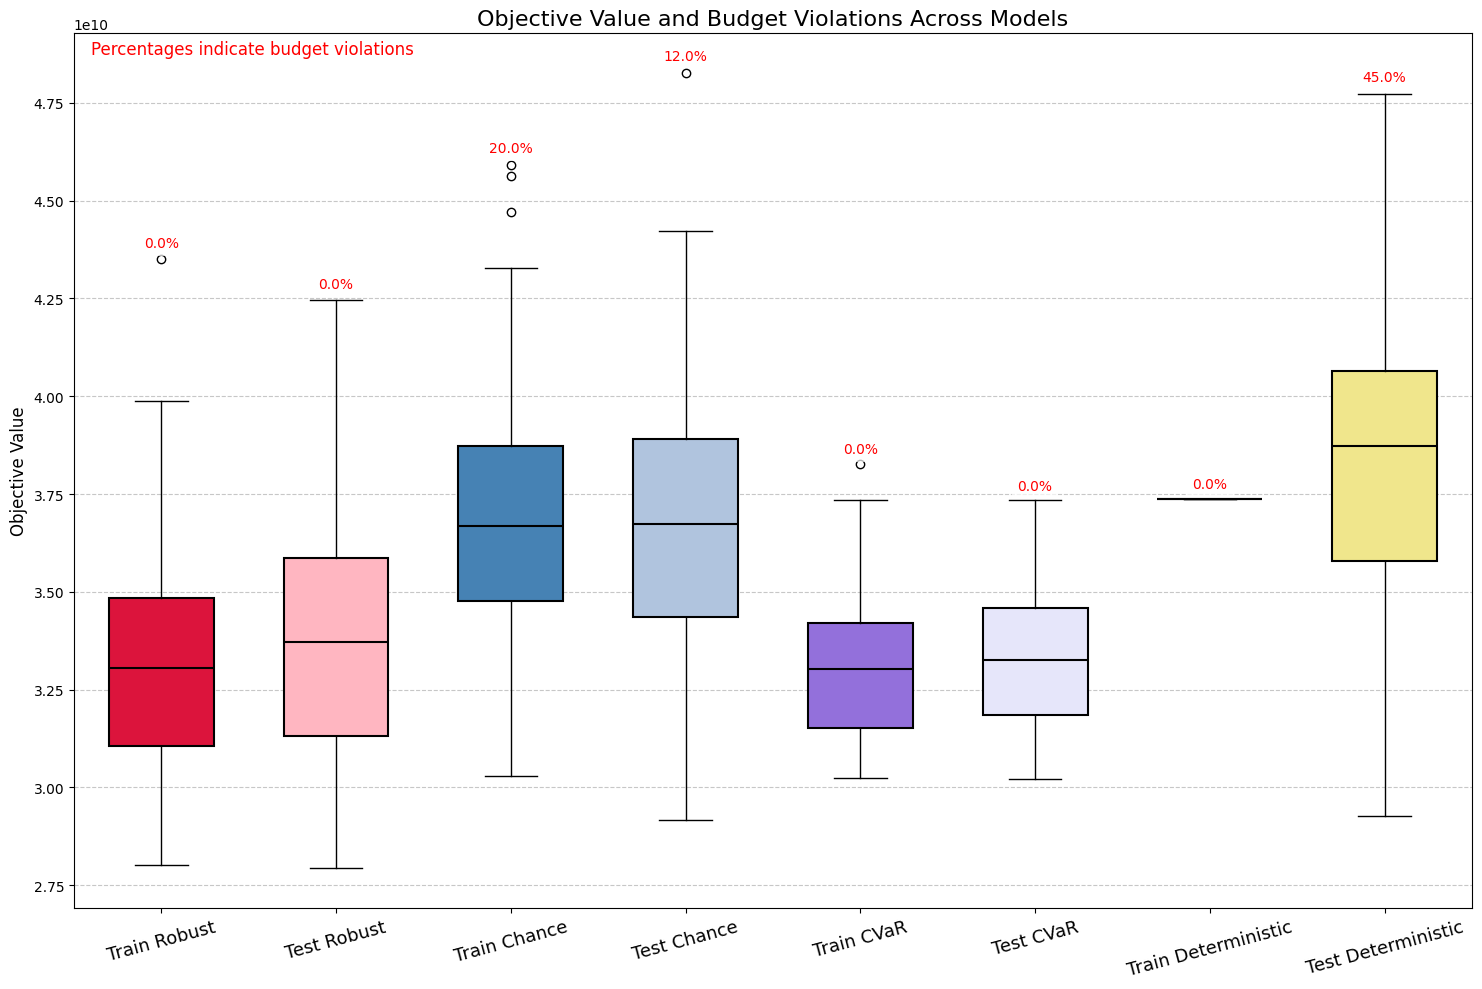

In [14]:
## PLOT THE RESULTS

# Data
objective_values = [
    Train_Robust.res.objective_values, Test_Robust.res.objective_values, 
    Train_Chance.res.objective_values, Test_Chance.res.objective_values, 
    Train_CVaR.res.objective_values, Test_CVaR.res.objective_values,
    Train_Deterministic.res.objective_values, Test_Deterministic.res.objective_values
]
labels = [
    'Train Robust', 'Test Robust', 
    'Train Chance', 'Test Chance', 
    'Train CVaR', 'Test CVaR',
    'Train Deterministic', 'Test Deterministic'
]
violated_percentages = [
    np.mean(Train_Robust.res.violated_budget) * 100, 
    np.mean(Test_Robust.res.violated_budget) * 100,
    np.mean(Train_Chance.res.violated_budget) * 100, 
    np.mean(Test_Chance.res.violated_budget) * 100,
    np.mean(Train_CVaR.res.violated_budget) * 100, 
    np.mean(Test_CVaR.res.violated_budget) * 100,
    np.mean(Train_Deterministic.res.violated_budget) * 100, 
    np.mean(Test_Deterministic.res.violated_budget) * 100
]

# Define color palette
colors_light = ['#FFB6C1', '#B0C4DE', '#E6E6FA', '#F0E68C']
colors_dark = ['#DC143C', '#4682B4', '#9370DB', '#FFD700']

# Plot
plt.figure(figsize=(15, 10))
for i, (values, label, violated_pct) in enumerate(zip(objective_values, labels, violated_percentages), start=1):
    color = colors_dark[(i-1)//2] if i % 2 == 1 else colors_light[(i-1)//2]
    plt.boxplot(values, positions=[i], widths=0.6, patch_artist=True, boxprops=dict(facecolor=color, color='black', linewidth=1.5), medianprops=dict(color='black', linewidth=1.5))
    plt.text( i, max(values) * 1.007, f'{violated_pct:.1f}%', ha='center', fontsize=10, color='red', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Axis labels and title
plt.xticks(range(1, len(labels) + 1), labels, rotation=15, fontsize=13)
plt.ylabel('Objective Value', fontsize=12)
plt.title('Objective Value and Budget Violations Across Models', fontsize=16)

# Gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Legend
plt.text(
    0.6, max(max(values) for values in objective_values) * 1.01, 
    'Percentages indicate budget violations', fontsize=12, color='red', ha='left'
)

# Tight layout and display
plt.tight_layout()
plt.show()


In [9]:
# Loop over Beta and run the model
Beta_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
Results_CVaR = []
Results_Expected_rev = []
for beta in Beta_values:
    Train_CVaR_Beta = Test_and_Train_model(ParametersObj, DataObj, MarketClearing1.res.DA_price, Mode='CVaR', Beta=beta, Alpha=0.95)
    Results_CVaR.append(Train_CVaR_Beta.res.CVaR)
    Results_Expected_rev.append(Train_CVaR_Beta.res.Expected_Result)



Set parameter Presolve to value 2
Set parameter Threads to value 4
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 4 threads

Optimize a model with 192456 rows, 192117 columns and 563056 nonzeros
Model fingerprint: 0x1a998c9e
Coefficient statistics:
  Matrix range     [4e-04, 2e+06]
  Objective range  [1e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+02, 3e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 192428 rows and 192101 columns
Presolve time: 0.16s
Presolved: 28 rows, 16 columns, 448 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.8800053e+10   2.047087e+07   0.000000e+00      0s
Extra simplex iterations after uncrush: 1
       5    3.2495930e+10  

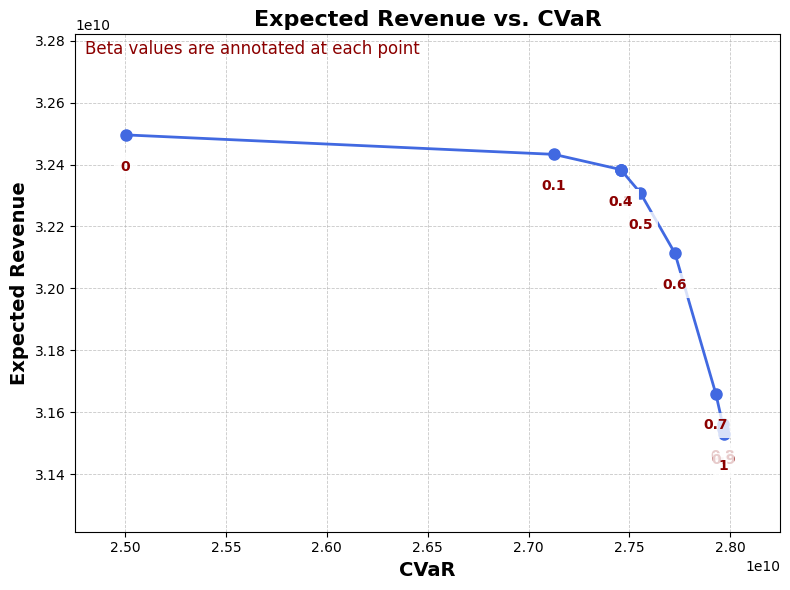

In [10]:
## PLOT THE RESULTS
plt.figure(figsize=(8, 6))  # Normal-sized dimensions

# Plot with consistent scaling for both axes
plt.plot(
    Results_CVaR, Results_Expected_rev, 
    marker='o', color='royalblue', linestyle='-', linewidth=2, markersize=8, label='Data Points'
)

# Set axis labels and title with professional formatting
plt.xlabel('CVaR', fontsize=14, fontweight='bold')
plt.ylabel('Expected Revenue', fontsize=14, fontweight='bold')
plt.title('Expected Revenue vs. CVaR', fontsize=16, fontweight='bold')

# Annotate each point with its beta value
for i, beta in enumerate(Beta_values):
    plt.text(
        Results_CVaR[i], Results_Expected_rev[i] - (0.0025 * Results_Expected_rev[i]), 
        f'{beta}', fontsize=10, color='darkred', fontweight='bold',
        ha='center', va='top', bbox=dict(facecolor='white', edgecolor='none', alpha=0.8)
    )

# Gridlines for clarity
plt.grid(visible=True, linestyle='--', linewidth=0.6, alpha=0.7)

# Adjusting axis limits for balanced visual spacing
plt.xlim(min(Results_CVaR) * 0.99, max(Results_CVaR) * 1.01)
plt.ylim(min(Results_Expected_rev) * 0.99, max(Results_Expected_rev) * 1.01)

# Add legend as a caption-like explanation
plt.text(
    min(Results_CVaR)* 0.992, max(Results_Expected_rev) * 1.008, 
    'Beta values are annotated at each point', fontsize=12, color='darkred'
)

# Tight layout to ensure everything fits well
plt.tight_layout()

# Display the plot
plt.show()




# Model 2: Integrated Bi-level optimization of dispatch problem and investment problem using KKTs

In [21]:
# ## CREATE THE PARAMETERS AND DATA OBJECTS
# ParametersObj_SHORT = Parameters(H, D, Y, 10, N_dem, N_gen_E, N_gen_N, N_zone, N_line, B, R)
# DataObj_SHORT = InputData(Dem[0:10,:], Uti, Load_Z, Gen_E_OpCost, Gen_N_OpCost, Gen_N_MaxInvCap, Gen_E_Cap, Gen_N_InvCost, Gen_E_Tech, Gen_N_Tech, Gen_E_Z, Gen_N_Z, Gen_E_OpCap[0:10,:], Gen_N_OpCap[0:10,:], Trans_React, Trans_Cap, Trans_Line_From_Z, Trans_Line_To_Z, Trans_Z_Connected_To_Z)

In [22]:
# class Model_2_no_zone():
#     def __init__(self, ParametersObj, DataObj, Model_results = 1, Guroby_results = 1):
#         self.P = ParametersObj # Parameters
#         self.D = DataObj # Data
#         self.Model_results = Model_results
#         self.Guroby_results = Guroby_results
#         self.var = Expando()  # Variables
#         self.con = Expando()  # Constraints
#         self.res = Expando()  # Results
#         self._build_model() 


#     def _build_variables(self):
#         self.var.P_N = self.m.addMVar((self.P.N_gen_N, 1), lb=0) # Invested capacity in every new generator
#         self.var.d = self.m.addMVar((self.P.N, self.P.N_dem), lb=0)  # demand per hour for every load
#         self.var.p_E = self.m.addMVar((self.P.N, self.P.N_gen_E), lb=0)  # power output per hour for every existing generator
#         self.var.p_N = self.m.addMVar((self.P.N, self.P.N_gen_N), lb=0) # Power output per hour for every new generator
        
#         # Dual variables
#         self.var.DA_Price = self.m.addMVar((self.P.N, 1), lb=-GRB.INFINITY)  # Day ahead price per hour
#         self.var.mu_E_up = self.m.addMVar((self.P.N, self.P.N_gen_E), lb=0)  # Dual 1
#         self.var.mu_E_down = self.m.addMVar((self.P.N, self.P.N_gen_E), lb=0)  # Dual 1
#         self.var.mu_N_up = self.m.addMVar((self.P.N, self.P.N_gen_N), lb=0)  # Dual 2
#         self.var.mu_N_down = self.m.addMVar((self.P.N, self.P.N_gen_N), lb=0)  # Dual 2
#         self.var.nu_up = self.m.addMVar((self.P.N, self.P.N_dem), lb=0)  # Dual 3
#         self.var.nu_down = self.m.addMVar((self.P.N, self.P.N_dem), lb=0)  # Dual 3
        
        

#     def _build_constraints(self):
#         # Capacity investment constraint
#         self.con.cap_inv = self.m.addConstr(self.var.P_N <= self.D.Gen_N_MaxInvCap, name='Maximum capacity investment')

#         # Budget constraint
#         self.con.budget = self.m.addConstr(self.var.P_N.T @ self.D.Gen_N_InvCost <= self.P.B, name='Budget constraint')

#         ## PRIMAL CONSTRAINTS
#         # Max production constraint existing
#         self.con.max_p_E = self.m.addConstr(self.var.p_E <= self.D.Gen_E_OpCap * (self.P.Sum_over_hours @ self.D.Gen_E_Cap.T), name='Maximum production of existing generators')

#         # Max production constraint new, in a different shape because we can't transpose varaibles
#         self.con.max_p_N = self.m.addConstrs(self.var.p_N[h, g] <= (self.D.Gen_N_OpCap[h, g] *  self.var.P_N[g].T) for h in range(self.P.N) for g in range(self.P.N_gen_N))

#         # Max demand constraint
#         self.con.max_dem = self.m.addConstr(self.var.d <= self.D.Dem, name='Maximum demand')        

#         # Balance constraint
#         prod_E = self.var.p_E @ self.P.Sum_over_gen_E  
#         prod_N = self.var.p_N @ self.P.Sum_over_gen_N  
#         dem = self.var.d @ self.P.Sum_over_dem
#         self.con.balance = self.m.addConstr(dem == prod_E + prod_N, name='Power balance') 

#         ## FIRST ORDER CONDITIONS

#         self.con.L_p_EC = self.m.addConstr(self.P.Sum_over_hours @ self.D.Gen_E_OpCost.T - self.var.DA_Price @ self.P.Sum_over_gen_E.T - self.var.mu_E_up + self.var.mu_E_down == 0, name='L_p_EC')
#         self.con.L_p_NC = self.m.addConstr(self.P.Sum_over_hours @ self.D.Gen_N_OpCost.T - self.var.DA_Price @ self.P.Sum_over_gen_N.T - self.var.mu_E_up + self.var.mu_E_down == 0, name='L_p_NC')
#         self.con.L_d = self.m.addConstr(- self.P.Sum_over_hours @ self.D.Uti.T + self.var.DA_Price @ self.P.Sum_over_dem.T - self.var.nu_up + self.var.nu_down == 0, name='L_d')
        

#         ## COMPLMEENTARY CONDITIONS

#         # Define the Big M matrixes

#         Big_M_p = np.full((self.P.N, self.P.N_gen_E), 1e3)  # Big M for the production constraints
#         Big_M_d = np.full((self.P.N, self.P.N_dem), 1e3)  # Big M for the demand constraints

#         # Define the binary variables

#         b_E_down = self.m.addVars(self.P.N, self.P.N_gen_E, vtype=gp.GRB.BINARY, name="b_E_down")
#         b_E_up = self.m.addVars(self.P.N, self.P.N_gen_E, vtype=gp.GRB.BINARY, name="b_E_up")

#         b_N_down = self.m.addVars(self.P.N, self.P.N_gen_N, vtype=gp.GRB.BINARY, name="b_N_down")
#         b_N_up = self.m.addVars(self.P.N, self.P.N_gen_N, vtype=gp.GRB.BINARY, name="b_N_up")

#         b_d_down = self.m.addVars(self.P.N, self.P.N_dem, vtype=gp.GRB.BINARY, name="b_d_down")
#         b_d_up = self.m.addVars(self.P.N, self.P.N_dem, vtype=gp.GRB.BINARY, name="b_d_up")

#         # Define the complementary constraints
#         # Existing generators
#         self.con.compl_E_down_mu = self.m.addConstrs((self.var.mu_E_down[h, g] <= Big_M_p[h, g] * b_E_down[h, g] for h in range(self.P.N) for g in range(self.P.N_gen_E)), name='compl_E_down_mu')
#         self.con.compl_E_down_p = self.m.addConstrs((self.var.p_E[h, g] <= Big_M_p[h, g] * (1 - b_E_down[h, g]) for h in range(self.P.N) for g in range(self.P.N_gen_E)), name='compl_E_down_p')
#         self.con.compl_E_up_mu = self.m.addConstrs((self.var.mu_E_up[h, g] <= Big_M_p[h, g] * b_E_up[h, g] for h in range(self.P.N) for g in range(self.P.N_gen_E)), name='compl_E_up_mu')
#         self.con.compl_E_up_p = self.m.addConstrs(((self.D.Gen_E_OpCap[h, g] - self.var.p_E[h, g]) <= Big_M_p[h, g] * (1 - b_E_up[h, g]) for h in range(self.P.N) for g in range(self.P.N_gen_E)), name='compl_E_up_p')

#         # New generators
#         self.con.compl_N_down_mu = self.m.addConstrs((self.var.mu_N_down[h, g] <= Big_M_p[h, g] * b_N_down[h, g] for h in range(self.P.N) for g in range(self.P.N_gen_N)), name='compl_N_down_mu')
#         self.con.compl_N_down_p = self.m.addConstrs((self.var.p_N[h, g] <= Big_M_p[h, g] * (1 - b_N_down[h, g]) for h in range(self.P.N) for g in range(self.P.N_gen_N)), name='compl_N_down_p')
#         self.con.compl_N_up_mu = self.m.addConstrs((self.var.mu_N_up[h, g] <= Big_M_p[h, g] * b_N_up[h, g] for h in range(self.P.N) for g in range(self.P.N_gen_N)), name='compl_N_up_mu')
#         self.con.compl_N_up_p = self.m.addConstrs(((self.D.Gen_N_OpCap[h, g] - self.var.p_N[h, g]) <= Big_M_p[h, g] * (1 - b_N_up[h, g]) for h in range(self.P.N) for g in range(self.P.N_gen_N)), name='compl_N_up_p')

#         # Demand
#         self.con.compl_d_down_mu = self.m.addConstrs((self.var.nu_down[h, d] <= Big_M_d[h, d] * b_d_down[h, d] for h in range(self.P.N) for d in range(self.P.N_dem)), name='compl_d_down_mu')
#         self.con.compl_d_down_p = self.m.addConstrs((self.var.d[h, d] <= Big_M_d[h, d] * (1 - b_d_down[h, d]) for h in range(self.P.N) for d in range(self.P.N_dem)), name='compl_d_down_p')
#         self.con.compl_d_up_mu = self.m.addConstrs((self.var.nu_up[h, d] <= Big_M_d[h, d] * b_d_up[h, d] for h in range(self.P.N) for d in range(self.P.N_dem)), name='compl_d_up_mu')
#         self.con.compl_d_up_p = self.m.addConstrs(((self.D.Dem[h, d] - self.var.d[h, d]) <= Big_M_d[h, d] * (1 - b_d_up[h, d]) for h in range(self.P.N) for d in range(self.P.N_dem)), name='compl_d_up_p')




#     def _build_objective(self):

#         # 1. Costs related to existing generators (G_EC)
#         cost_EC_p = (self.var.p_E @ self.D.Gen_E_OpCost).sum()
#         cost_EC_mu = ((self.D.Gen_E_OpCap * (self.P.Sum_over_hours @ self.D.Gen_E_Cap.T)) * self.var.mu_E_up).sum()

#         # 2. Benefits and costs related to demand (D)
#         benefit_d = (self.var.d @ self.D.Uti).sum()
#         cost_nu_d = (self.D.Dem * self.var.nu_up).sum()

#         # 3. Costs related to new generators (G_NC)
#         cost_NC_p = (self.var.p_N @ self.D.Gen_N_OpCost).sum()
#         cost_NC_P = (self.var.P_N.T @ self.D.Gen_N_InvCost).sum()

#         # Full objective function
#         self.m.setObjective(
#             - cost_EC_p - cost_EC_mu  # Existing generators
#             + benefit_d - cost_nu_d   # Demand
#             - cost_NC_p - cost_NC_P,  # New generators
#             gp.GRB.MAXIMIZE
#         )

        


#     def _display_guropby_results(self):
#         self.m.setParam('OutputFlag', self.Guroby_results)
#         #self.m.setParam('Method', 2)  # Use barrier method
#         #self.m.setParam('Crossover', 0)  # Skip crossover for speed
#         #self.m.setParam('Heuristics', 0.2)  # Enable aggressive heuristics
#         #self.m.setParam('MIPFocus', 1)  # Focus on finding feasible solutions
    

#     def _build_model(self):
#         self.m = gp.Model('Model 2')
#         self._build_variables()  
#         self._build_constraints()
#         self._build_objective()
#         self._display_guropby_results()
#         self.m.optimize()
#         if self.Model_results == 1:
#             self._extract_results()

#     def _extract_results(self):
#         # Display the objective value
#         print('Objective value: ', self.m.objVal)
        
#         # Display the generators the model invested in, in a dataframe
#         self.res.P_N = self.var.P_N.X
#         self.res.P_N = self.res.P_N.reshape((self.P.N_gen_N,1))
#         self.res.df = pd.DataFrame(self.D.Gen_N_Tech, columns = ['Technology'])
#         self.res.df['Invested capacity (MW)'] = self.res.P_N
            

        

In [23]:
# Model2NZ = Model_2_no_zone(ParametersObj_SHORT, DataObj_SHORT)